In [1]:
import numpy as np
import wandb
wandb.login(key=input())

wandb: Currently logged in as: gabi-kadlecova. Use `wandb login --relogin` to force relogin


True

In [175]:
project = 'zc_nb201'

api = wandb.Api(timeout=29)
runs = api.runs('gabi-kadlecova' + "/" + project)

In [176]:
res = []
for run in runs:
    # skip xgb for now
    if run.config['model'] != 'rf':
        continue
        
    if 'threshold' not in run.config['out_prefix']:
        continue
    
    #print(run.summary['corr_mean'])
    #print(run.config)
    res.append((run.config['train_size'], run.config['data_seed'], run.summary['corr_mean'], len({k: v for k, v in run.summary.items() if 'featimp' in k and 'mean' in k})))
    #print({k: v for k, v in run.summary.items() if 'featimp' in k})
    
    #if i > 10:
    #    break
    #i += 1
    #break

In [177]:
import pandas as pd

def create_entry(run, is_pca=False):
    # TODO uncertainty
    row = {}
    cfg_args = ['cfg', 'data_seed', 'proxy', 'train_size', 'use_all_proxies', 'use_features']
    for ca in cfg_args:
        row[ca] = run.config[ca]
        
    if is_pca:
        prefix = run.config['out_prefix']
        prefix = prefix.replace('n_features-', 'nfeatures_')
        prefix = prefix.replace('theshold-', 'theshold_')

        prefix = prefix.split('-')
        for p in prefix:
            if not len(p):
                continue  
            p = p.split('_')
            if len(p) == 1:
                continue
            
            row[p[0]] = p[1]

    prox, cfg = row['proxy'], row['cfg']
    row['proxy'] = 'NONE' if prox is None or not len(prox) else prox
    row['cfg'] = 'NONE' if cfg is None or not len(cfg) else cfg
    row['corr'] = run.summary['corr_mean']
    row['tau'] = run.summary['tau_mean']
    return row

df = [create_entry(r, is_pca='pca' in project) for r in runs]
df = pd.DataFrame(df)
df

,cfg,data_seed,proxy,train_size,use_all_proxies,use_features,corr,tau
0,../zc_combine/configs/nb201_full.json,46,jacov,614,False,True,0.961458,0.833836
1,../zc_combine/configs/nb201_full.json,46,NONE,614,False,True,0.938660,0.798849
2,../zc_combine/configs/nb201_full.json,46,NONE,614,True,True,0.958938,0.830036
3,../zc_combine/configs/nb201_first.json,46,jacov,614,False,True,0.951678,0.814647
4,../zc_combine/configs/nb201_first.json,46,NONE,614,True,True,0.955394,0.822723
...,...,...,...,...,...,...,...,...
505,NONE,42,NONE,1000,True,False,0.940985,0.792016
506,NONE,42,NONE,100,True,False,0.901894,0.729372
507,NONE,42,NONE,100,True,False,0.914283,0.746074
508,NONE,42,NONE,20,True,False,0.873683,0.685865


In [178]:
import numpy as np

plot_df = df.copy()
plot_df['use_all_proxies'] = df['use_all_proxies'].map(lambda x: 'A' if x else 'N')
if 'pca' in project:
    plot_df['threshold'] = df['threshold'].map(lambda x: 'N' if pd.isna(x) else str(x))
    plot_df['nfeatures'] = df['nfeatures'].map(lambda x: 'N' if pd.isna(x) else str(x))
    plot_df['plot_col'] = plot_df[['proxy', 'use_all_proxies', 'threshold', 'nfeatures']].agg(', '.join, axis=1)
else:
    plot_df['use_features'] = df['use_features'].map(lambda x: 'F' if x else 'P')
    plot_df['plot_col'] = plot_df[['proxy', 'use_all_proxies', 'use_features']].agg(', '.join, axis=1)

plot_df['plot_col']

0      jacov, N, F
1       NONE, N, F
2       NONE, A, F
3      jacov, N, F
4       NONE, A, F
          ...     
505     NONE, A, P
506     NONE, A, P
507     NONE, A, P
508     NONE, A, P
509     NONE, A, P
Name: plot_col, Length: 510, dtype: object

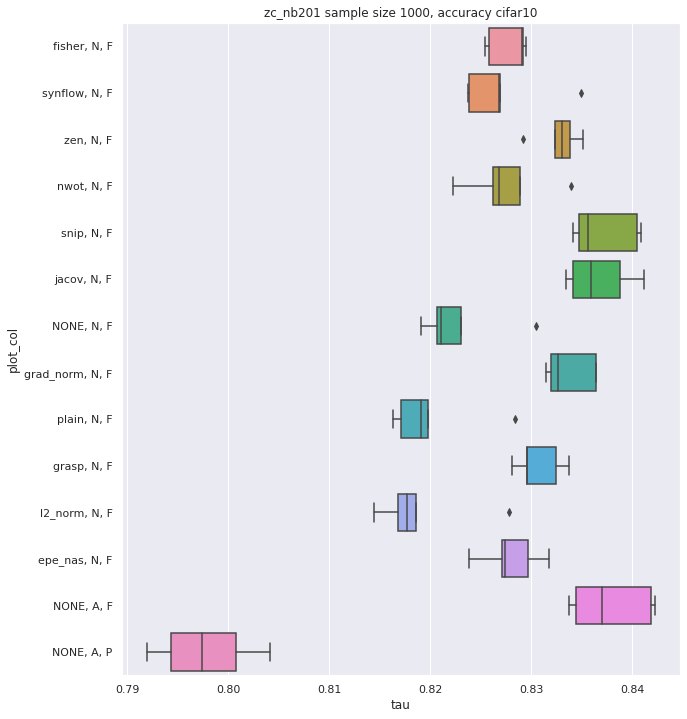

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

tsize = 1000
plt.figure(figsize=(10, 12))
sns.boxplot(data=plot_df[(plot_df['train_size'] == tsize) & ~(plot_df['cfg'].str.contains('first'))], y='plot_col', x='tau')
plt.title(f"{project} sample size {tsize}, accuracy cifar10")
if 'pca' not in project:
    plt.savefig(f'figs/{project}_boxes_{tsize}.png')
#plt.ylim(0.70, 0.78)
plt.show()

In [180]:
sns.boxplot(data=df, x='corr', y='')

ValueError: Could not interpret input ''

In [ ]:
what_cfg = 'full'
group_cols = ['train_size', 'use_all_proxies', 'use_features', 'proxy']

small_df = df[(df['cfg'].str.contains('NONE')) | (df['cfg'].str.contains(what_cfg))].drop(columns='cfg')
small_df.groupby(group_cols).mean()

In [6]:
#####################################################
from copy import deepcopy


def topology_str2structure(xstr):
    return TopologyStructure.str2structure(xstr)


class TopologyStructure:
    """A class to describe the topology, especially that used in NATS-Bench."""

    def __init__(self, genotype):
        assert isinstance(genotype, list) or isinstance(
            genotype, tuple
        ), "invalid class of genotype : {:}".format(type(genotype))
        self.node_num = len(genotype) + 1
        self.nodes = []
        self.node_N = []
        for idx, node_info in enumerate(genotype):
            assert isinstance(node_info, list) or isinstance(
                node_info, tuple
            ), "invalid class of node_info : {:}".format(type(node_info))
            assert len(node_info) >= 1, "invalid length : {:}".format(len(node_info))
            for node_in in node_info:
                assert isinstance(node_in, list) or isinstance(
                    node_in, tuple
                ), "invalid class of in-node : {:}".format(type(node_in))
                assert (
                    len(node_in) == 2 and node_in[1] <= idx
                ), "invalid in-node : {:}".format(node_in)
            self.node_N.append(len(node_info))
            self.nodes.append(tuple(deepcopy(node_info)))

    def tolist(self, remove_str):
        # convert this class to the list, if remove_str is 'none', then remove the 'none' operation.
        # note that we re-order the input node in this function
        # return the-genotype-list and success [if unsuccess, it is not a connectivity]
        genotypes = []
        for node_info in self.nodes:
            node_info = list(node_info)
            node_info = sorted(node_info, key=lambda x: (x[1], x[0]))
            node_info = tuple(filter(lambda x: x[0] != remove_str, node_info))
            if len(node_info) == 0:
                return None, False
            genotypes.append(node_info)
        return genotypes, True

    def node(self, index):
        assert index > 0 and index <= len(self), "invalid index={:} < {:}".format(
            index, len(self)
        )
        return self.nodes[index]

    def tostr(self):
        strings = []
        for node_info in self.nodes:
            string = "|".join([x[0] + "~{:}".format(x[1]) for x in node_info])
            string = "|{:}|".format(string)
            strings.append(string)
        return "+".join(strings)

    def check_valid(self):
        nodes = {0: True}
        for i, node_info in enumerate(self.nodes):
            sums = []
            for op, xin in node_info:
                if op == "none" or nodes[xin] is False:
                    x = False
                else:
                    x = True
                sums.append(x)
            nodes[i + 1] = sum(sums) > 0
        return nodes[len(self.nodes)]

    def to_unique_str(self, consider_zero=False):
        # this is used to identify the isomorphic cell, which rerquires the prior knowledge of operation
        # two operations are special, i.e., none and skip_connect
        nodes = {0: "0"}
        for i_node, node_info in enumerate(self.nodes):
            cur_node = []
            for op, xin in node_info:
                if consider_zero is None:
                    x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                elif consider_zero:
                    if op == "none" or nodes[xin] == "#":
                        x = "#"  # zero
                    elif op == "skip_connect":
                        x = nodes[xin]
                    else:
                        x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                else:
                    if op == "skip_connect":
                        x = nodes[xin]
                    else:
                        x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                cur_node.append(x)
            nodes[i_node + 1] = "+".join(sorted(cur_node))
        return nodes[len(self.nodes)]

    def check_valid_op(self, op_names):
        for node_info in self.nodes:
            for inode_edge in node_info:
                # assert inode_edge[0] in op_names, 'invalid op-name : {:}'.format(inode_edge[0])
                if inode_edge[0] not in op_names:
                    return False
        return True

    def __repr__(self):
        return "{name}({node_num} nodes with {node_info})".format(
            name=self.__class__.__name__, node_info=self.tostr(), **self.__dict__
        )

    def __len__(self):
        return len(self.nodes) + 1

    def __getitem__(self, index):
        return self.nodes[index]

    @staticmethod
    def str2structure(xstr):
        if isinstance(xstr, TopologyStructure):
            return xstr
        assert isinstance(xstr, str), "must take string (not {:}) as input".format(
            type(xstr)
        )
        nodestrs = xstr.split("+")
        genotypes = []
        for i, node_str in enumerate(nodestrs):
            inputs = list(filter(lambda x: x != "", node_str.split("|")))
            for xinput in inputs:
                assert len(xinput.split("~")) == 2, "invalid input length : {:}".format(
                    xinput
                )
            inputs = (xi.split("~") for xi in inputs)
            input_infos = tuple((op, int(IDX)) for (op, IDX) in inputs)
            genotypes.append(input_infos)
        return TopologyStructure(genotypes)

    @staticmethod
    def str2fullstructure(xstr, default_name="none"):
        assert isinstance(xstr, str), "must take string (not {:}) as input".format(
            type(xstr)
        )
        nodestrs = xstr.split("+")
        genotypes = []
        for i, node_str in enumerate(nodestrs):
            inputs = list(filter(lambda x: x != "", node_str.split("|")))
            for xinput in inputs:
                assert len(xinput.split("~")) == 2, "invalid input length : {:}".format(
                    xinput
                )
            inputs = (xi.split("~") for xi in inputs)
            input_infos = list((op, int(IDX)) for (op, IDX) in inputs)
            all_in_nodes = list(x[1] for x in input_infos)
            for j in range(i):
                if j not in all_in_nodes:
                    input_infos.append((default_name, j))
            node_info = sorted(input_infos, key=lambda x: (x[1], x[0]))
            genotypes.append(tuple(node_info))
        return TopologyStructure(genotypes)

    @staticmethod
    def gen_all(search_space, num, return_ori):
        assert isinstance(search_space, list) or isinstance(
            search_space, tuple
        ), "invalid class of search-space : {:}".format(type(search_space))
        assert (
            num >= 2
        ), "There should be at least two nodes in a neural cell instead of {:}".format(
            num
        )
        all_archs = get_combination(search_space, 1)
        for i, arch in enumerate(all_archs):
            all_archs[i] = [tuple(arch)]

        for inode in range(2, num):
            cur_nodes = get_combination(search_space, inode)
            new_all_archs = []
            for previous_arch in all_archs:
                for cur_node in cur_nodes:
                    new_all_archs.append(previous_arch + [tuple(cur_node)])
            all_archs = new_all_archs
        if return_ori:
            return all_archs
        else:
            return [TopologyStructure(x) for x in all_archs]

In [9]:
struct = topology_str2structure('|nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|')

In [10]:
struct.nodes

[(('nor_conv_3x3', 0),),
 (('nor_conv_3x3', 0), ('avg_pool_3x3', 1)),
 (('skip_connect', 0), ('nor_conv_3x3', 1), ('skip_connect', 2))]